## Schematic Representation of GNN Model

The idea is that the taxi zones exhibit some spatial correlations (e.g., the demand in one taxi zone can affect the demand in neighboring taxi zones). Since our data is not in the form of a square grid, standard CNNs are not an option for capturing these correlations. Instead, we do this using the more general graph neural network framework. 

Spatially, the data exhibits the following graph structure:

A visualization of the graph is given below:

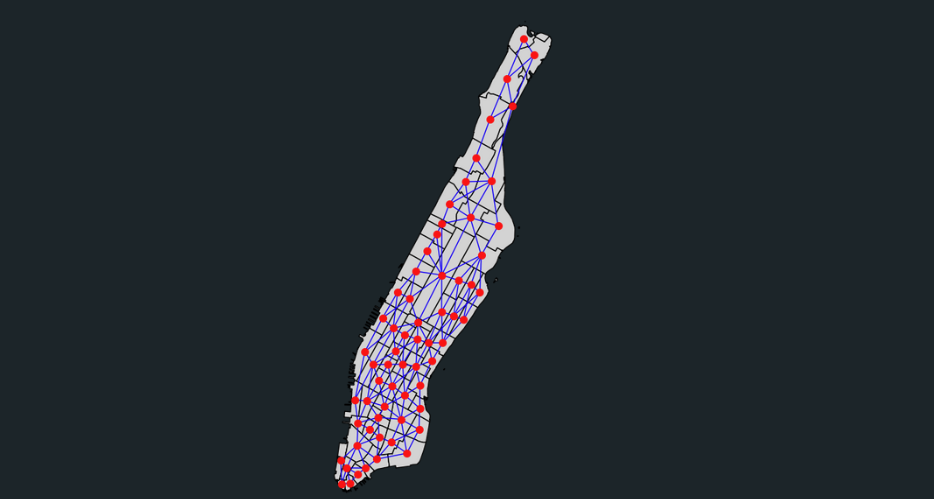

That is, the graph is specified by the following:
* Graph nodes:  Taxi zones
* Node features: Number of counts
* Graph edges: Pairs of taxi zones
* Graph weights: Distance between pair of taxi zones (normalized from 0 to 1)
The weights of the graph determine the extent to which neighboring taxi zones affect one another.

Our data also has temporal structure, which handled by the model with an LSTM network. Thinking of the data as snapshots, predictions are made as follows:

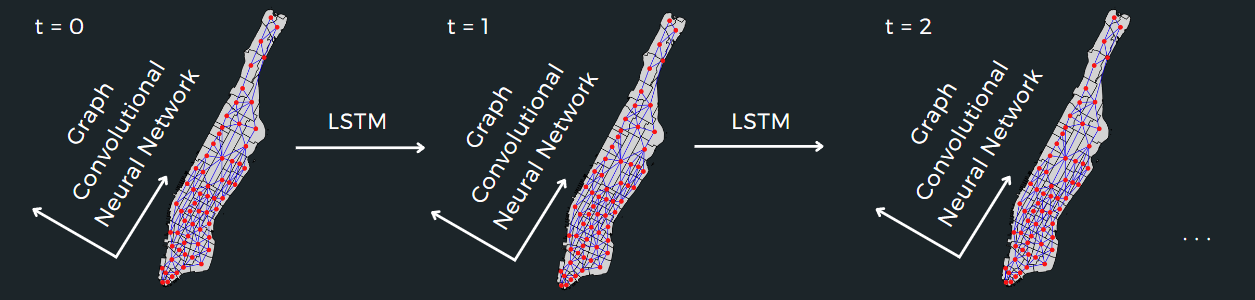

The LSTM will make predictions based on the data from the previous 24 hours (referred to as the `lag`).

## Dependencies
This notebook mainly relies on the `torch-geometric-temporal` module for training models on spatial-temporal data.

We use Google Colab to run this code, though training the model on a CPU is just as fast as a GPU. I strongly recommend you just install it locally.

Nevertheless, to use this code on Colab. To prevent having to install the modules each time we run the code, please see this [Colab Notebook](https://colab.research.google.com/github/edwarddramirez/taxi-forecast/blob/main/assets/colab/01_pytgt_test.ipynb) for instructions toa permanently installing the packages on your Google Drive.

## Load Packages

In [1]:
import os, sys
from google.colab import drive
drive.mount('/content/mnt')
nb_path = '/content/notebooks'
os.symlink('/content/mnt/My Drive/taxi_colab', nb_path)
sys.path.insert(0, nb_path)  # or append(nb_path)

Mounted at /content/mnt


In [2]:
# instant if installed, ~10 min if loading from Drive
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import geopandas as gpd
from sklearn.utils.extmath import cartesian
from geopy.distance import geodesic

import torch
import torch_geometric
import torch_geometric_temporal

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

### Load Data

In [3]:
ts = pd.read_pickle('/content/mnt/My Drive/taxi_data/adjusted_yellow_2022-01_2024-03_bypulocation.pkl')
gdf = gpd.GeoDataFrame(pd.read_pickle('/content/mnt/My Drive/taxi_data/manhattan_taxi_zones.pkl'))

## Define Edges
#### Edge Indices [Shape (2,N)]

In [4]:
# relate old ids and new ids with a dictionary
old_ids = ts['PULocationID'].unique()
new_ids = list(range(len(ts['PULocationID'].unique())))
mapping = dict(zip(old_ids, new_ids))

# renumber locationids starting from 0
ts['PULocationID'] = ts['PULocationID'].map(mapping)
gdf['LocationID'] = gdf['LocationID'].map(mapping)

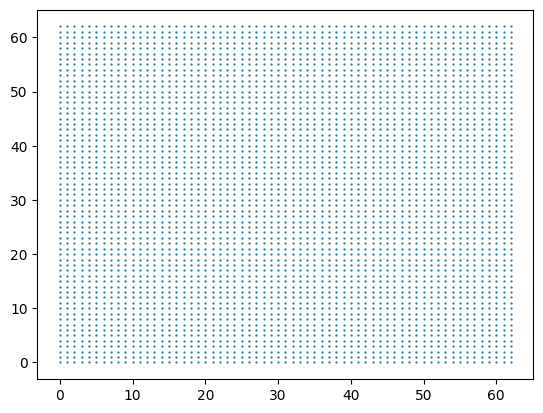

In [5]:
# Example edge index (assume static for simplicity)
edge_index = np.array([
    [n for n in range(len(gdf)) for _ in range(len(gdf))],  # Source nodes
    [n for _ in range(len(gdf)) for n in range(len(gdf))]   # Target nodes
], dtype=np.int32)

plt.scatter(edge_index[0,:], edge_index[1,:], s = 0.4)

In [6]:
# compute distances for each node by leveraging that index of gdf matches with locationids
distances = []
for i in tqdm(range(edge_index.shape[-1])):
  pulocation = edge_index[0,i] ; dolocation = edge_index[1,i]
  pu_lon = gdf.iloc[pulocation].lon ; pu_lat = gdf.iloc[pulocation].lat
  do_lon = gdf.iloc[dolocation].lon ; do_lat = gdf.iloc[dolocation].lat
  distances.append(geodesic((pu_lat, pu_lon), (do_lat, do_lon)).meters)
distances = np.array(distances)

  0%|          | 0/3969 [00:00<?, ?it/s]

In [7]:
# example
pulocation = 21
dolocation = 34
idx = 63 * 21 + 34
print('The Distance Between Zone {} and Zone {} is {}'.format(edge_index[0,idx], edge_index[1,idx], distances[idx]))

The Distance Between Zone 21 and Zone 34 is 1097.3567770103864


### Edge Weights [Shape (N,)]

In [8]:
# define edge weights via inverse distances, normalize from 0 to 1 (standard approach doesn't work)
edge_weights = distances
edge_weights = (edge_weights - edge_weights.min()) / (edge_weights.max() - edge_weights.min())
edge_weights = 1. - edge_weights

In [9]:
# as expected, the strongest weights are assigned to loops
edge_index[0, edge_weights == 1.], edge_index[1, edge_weights == 1.]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62], dtype=int32),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62], dtype=int32))

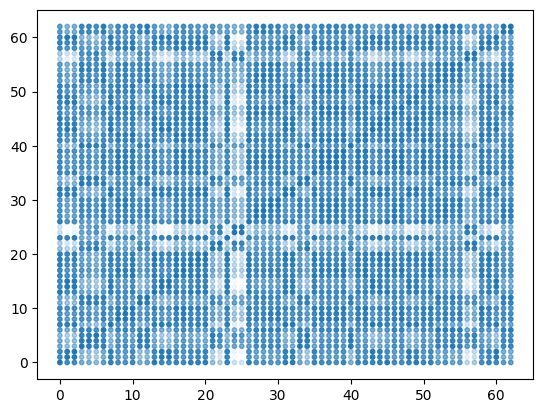

In [10]:
# visualizing the weights (diagonal should correspond to maximum edges)
plt.scatter(edge_index[0,:], edge_index[1,:], s = 10, alpha = edge_weights)

### Node Features [Shape (T, N, O)]
All of my hard work with edge features paid off. Because everything goes as before.

In [11]:
# double-check for null values in data
print(ts.isnull().sum())

# for now, just replace these values with 0 and fix later
ts = ts.fillna(0)

PULocationID       0
pickup_datetime    0
counts             0
total_amount       0
tip_amount         0
fare_amount        0
trip_distance      0
passenger_count    0
trip_duration      0
dtype: int64


In [12]:
# create the numpy version of dataframe by pivoting dataframe
output_columns = ['counts', 'total_amount', 'tip_amount', 'fare_amount', 'trip_distance', 'passenger_count', 'trip_duration']
pivoted_ts = ts.pivot_table(index='pickup_datetime', columns='PULocationID', values=output_columns, aggfunc='first', sort = False) # sort = False to preserve order of columns

# Convert to a NumPy array
node_features = pivoted_ts.to_numpy()

# Reshape the array to the desired shape
num_times = len(ts['pickup_datetime'].unique())
num_nodes = len(ts['PULocationID'].unique())
num_outputs = len(output_columns)

In [13]:
pivoted_ts

counts                                     ...  \
PULocationID                  0  1   2   3   4  5   6  7    8    9   ...   
pickup_datetime                                                      ...   
2022-01-01 00:00:00-05:00      8  1  10  10   9  2  89  9  136   69  ...   
2022-01-01 01:00:00-05:00      9  0   6  13  13  4  54  4  195  100  ...   
2022-01-01 02:00:00-05:00     22  0   3   3   5  5  19  3  191   90  ...   
2022-01-01 03:00:00-05:00      5  0   0   2  12  3   7  1  162   38  ...   
2022-01-01 04:00:00-05:00      5  0   0   2   2  0   4  1  102   19  ...   
...                          ... ..  ..  ..  .. ..  .. ..  ...  ...  ...   
2024-03-31 19:00:00-04:00      4  2  20   6   4  2  63  6  109   17  ...   
2024-03-31 20:00:00-04:00      2  3  12  15  12  4  29  7  118   18  ...   
2024-03-31 21:00:00-04:00      4  0   3   8   6  4  25  3  117   13  ...   
2024-03-31 22:00:00-04:00      1  0   3   2   7  0  12  1  100    4  ...   
2024-03-31 23:00:00-04:00      0  0   2   1   4  2   3  2   72    5  ...   

                          trip_duration                                   \
PULocationID                         53         54         55         56   
pickup_datetime                                                            
2022-01-01 00:00:00-05:00     10.074516  10.403095  10.272392  11.833333   
2022-01-01 01:00:00-05:00      9.158504   9.983056  10.541358  17.032413   
2022-01-01 02:00:00-05:00      7.881560  10.727083  10.994552   8.566667   
2022-01-01 03:00:00-05:00      8.240351   9.244445  10.346492  17.032413   
2022-01-01 04:00:00-05:00      7.272223   7.994444   8.795556  17.032413   
...                                 ...        ...        ...        ...   
2024-03-31 19:00:00-04:00      8.246714  10.106667   9.463141  17.032413   
2024-03-31 20:00:00-04:00      7.970671   8.883871  10.075238   5.650000   
2024-03-31 21:00:00-04:00      9.343148   9.805443   9.776256   7.700000   
2024-03-31 22:00:00-04:00      9.310417   9.627381  10.246511  17.032413   
2024-03-31 23:00:00-04:00      9.284000   9.886111  11.026470  17.032413   

                                                                       \
PULocationID                      57         58         59         60   
pickup_datetime                                                         
2022-01-01 00:00:00-05:00  11.127777  14.168571  12.456313  14.230000   
2022-01-01 01:00:00-05:00  11.641667  11.968493  12.220030  14.291111   
2022-01-01 02:00:00-05:00  15.168828  12.137797  11.012191  15.910605   
2022-01-01 03:00:00-05:00  15.168828  10.183088  10.190166  16.777084   
2022-01-01 04:00:00-05:00   2.416667   9.840740  11.881112   8.258333   
...                              ...        ...        ...        ...   
2024-03-31 19:00:00-04:00  12.250000  12.710000  11.431362  18.170139   
2024-03-31 20:00:00-04:00   7.983333  10.718287  11.705976  18.202564   
2024-03-31 21:00:00-04:00  12.756666  11.210677  11.620797  12.886667   
2024-03-31 22:00:00-04:00   9.433333  12.481046  12.170444  12.500000   
2024-03-31 23:00:00-04:00  11.383333   8.076283   9.940179   5.641666   

                                                
PULocationID                      61        62  
pickup_datetime                                 
2022-01-01 00:00:00-05:00   9.255915  7.873433  
2022-01-01 01:00:00-05:00   7.202899  8.452817  
2022-01-01 02:00:00-05:00   7.953968  8.219406  
2022-01-01 03:00:00-05:00   7.525000  7.188798  
2022-01-01 04:00:00-05:00  10.766666  7.809896  
...                              ...       ...  
2024-03-31 19:00:00-04:00  10.110215  7.688675  
2024-03-31 20:00:00-04:00   9.098889  8.332857  
2024-03-31 21:00:00-04:00   9.196875  8.524590  
2024-03-31 22:00:00-04:00   9.177084  8.896795  
2024-03-31 23:00:00-04:00   6.876666  6.676984  

[19627 rows x 441 columns]

In [14]:
# trick in getting pivot_table to work:
# see scratch/df_to_np.ipynb where I found the solution by working with toy data

# reshape manually to get the desired shape
idx = np.arange(0, num_outputs*num_nodes).reshape((num_outputs, num_nodes))
idx.T.flatten()
node_features = node_features[:, idx.T.flatten()].reshape((num_times, num_nodes, num_outputs))

In [15]:
node_features[0,0,:]

array([ 8.        , 23.24238777,  1.88651264, 16.68187523,  3.36374998,
        1.375     , 14.48124981])

## Train-Test Split

In [17]:
# Create node features
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
from torch_geometric_temporal.signal import temporal_signal_split

lags = 24
train_ratio = 0.8

mean_features = np.mean(node_features, axis=0)
std_features = np.std(node_features, axis=0)
standardized_features = (
    node_features - mean_features
) / std_features

features = [
    standardized_features[i : i + lags, :, 0].T
    for i in range(node_features.shape[0] - lags)
]
targets = [
    standardized_features[i + lags, :, 0].T
    for i in range(node_features.shape[0] - lags)
]
dataset = StaticGraphTemporalSignal(edge_index, edge_weights, features, targets)
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=train_ratio)


In [64]:
print(train_dataset.snapshot_count, test_dataset.snapshot_count)
print(pivoted_ts.index[15682])

15682 3921
2023-10-19 14:00:00-04:00


## Define Model + Fit

In [18]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GConvLSTM

class LSTMGCN(torch.nn.Module):
    def __init__(self, node_features, out_channels):
        super(LSTMGCN, self).__init__()
        self.recurrent = GConvLSTM(node_features, out_channels, K = 1, normalization = 'sym')
        self.linear = torch.nn.Linear(out_channels, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h[0])
        h = self.linear(h)
        return h

In [194]:
N_epochs = 20
N_snapshots = train_dataset.snapshot_count
model = LSTMGCN(node_features=lags, out_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9995)

model.train()

# N_snapshots = int(np.floor((len(node_features) - lags) * train_ratio))
pbar_epoch = tqdm(range(N_epochs), desc = 'Epoch: ', position = 0)

train_losses = val_losses = []
min_val_loss = torch.inf
counter = 0
for epoch in pbar_epoch:
    losses = []
    pbar_time = tqdm(range(N_snapshots), desc = 'Time: ', position = 1)
    for time in pbar_time:
        snapshot = train_dataset[time]
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        loss = torch.mean((y_hat-torch.unsqueeze(snapshot.y, -1))**2)
        loss.backward()
        losses.append(loss)
        optimizer.step()
        optimizer.zero_grad()

        if time % 50 == 0:
          pbar_time.set_postfix_str("Avg Snapshot Loss: {:.6f}".format(
                  sum(losses[-50:]) / 50
              ))

    losses = torch.tensor(losses)
    train_loss = losses.sum() / (time + 1)

    with torch.no_grad():
      val_loss = 0
      for time, snapshot in enumerate(test_dataset):
          y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
          val_loss = val_loss + torch.mean((y_hat-torch.unsqueeze(snapshot.y, -1))**2)
      val_loss = val_loss / (time+1)
      val_loss = val_loss.item()

    # early stopping
    if val_loss < min_val_loss:
      min_val_loss = val_loss
      counter = 0
    else:
      counter += 1

    if counter == 5:
      break

    pbar_epoch.set_postfix_str("Train Loss: {:.6f}, Val Loss: {:.6f}, Early Stop Counts: {}: ".format(
        train_loss, val_loss, counter
    ))

    train_losses.append(train_loss)
    val_losses.append(val_loss)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Time:   0%|          | 0/15682 [00:00<?, ?it/s]

Time:   0%|          | 0/15682 [00:00<?, ?it/s]

Time:   0%|          | 0/15682 [00:00<?, ?it/s]

Time:   0%|          | 0/15682 [00:00<?, ?it/s]

Time:   0%|          | 0/15682 [00:00<?, ?it/s]

Time:   0%|          | 0/15682 [00:00<?, ?it/s]

Time:   0%|          | 0/15682 [00:00<?, ?it/s]

Time:   0%|          | 0/15682 [00:00<?, ?it/s]

Time:   0%|          | 0/15682 [00:00<?, ?it/s]

Time:   0%|          | 0/15682 [00:00<?, ?it/s]

Time:   0%|          | 0/15682 [00:00<?, ?it/s]

Time:   0%|          | 0/15682 [00:00<?, ?it/s]

Time:   0%|          | 0/15682 [00:00<?, ?it/s]

Time:   0%|          | 0/15682 [00:00<?, ?it/s]

Time:   0%|          | 0/15682 [00:00<?, ?it/s]

Time:   0%|          | 0/15682 [00:00<?, ?it/s]

Time:   0%|          | 0/15682 [00:00<?, ?it/s]

Time:   0%|          | 0/15682 [00:00<?, ?it/s]

Time:   0%|          | 0/15682 [00:00<?, ?it/s]

Time:   0%|          | 0/15682 [00:00<?, ?it/s]

## Compute Performance Metrics

In [195]:
model.eval()
cost = 0
y_pred = []
y_act = []
t_std_features = torch.tensor(std_features.copy())[:,0,None]
t_mean_features = torch.tensor(mean_features.copy())[:,0,None]
for time, snapshot in enumerate(test_dataset):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr) * t_std_features + t_mean_features
    y_t = torch.unsqueeze(snapshot.y, -1) * t_std_features + t_mean_features
    cost = cost + torch.mean((y_hat-y_t)**2)
    y_pred.append(y_hat)
    y_act.append(snapshot.y)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 291.9391


In [207]:
model.eval()
cost = 0
y_pred = []
y_act = []
t_std_features = torch.tensor(std_features.copy())[:,0,None]
t_mean_features = torch.tensor(mean_features.copy())[:,0,None]
for time, snapshot in enumerate(test_dataset):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr) * t_std_features + t_mean_features
    y_t = torch.unsqueeze(snapshot.y, -1) * t_std_features + t_mean_features
    cost = cost + torch.mean(2. * torch.abs(y_hat-y_t) / ( torch.abs(y_t) + torch.abs(y_hat) ) )
    y_pred.append(y_hat)
    y_act.append(y_t)
cost = cost / (time+1)
cost = cost.item()
print("sMAPE: {:.4f}".format(cost))

sMAPE: 0.5538


## Performance Visualization

In [208]:
y_pred_np = torch.stack(y_pred).detach().numpy()
y_act_np = torch.stack(y_act).detach().numpy()

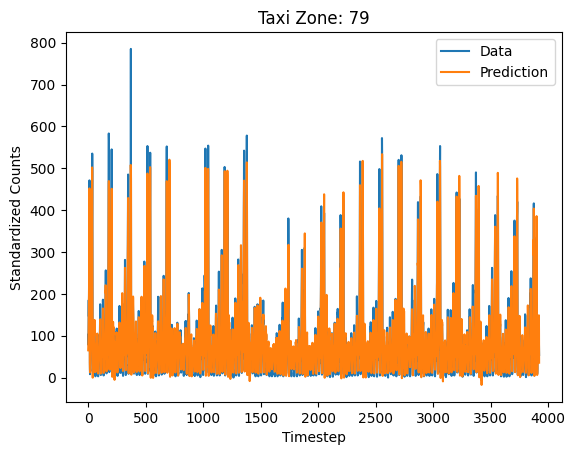

In [209]:
idx = mapping[79]
plt.plot(y_act_np[:,idx], label = 'Data')
plt.plot(y_pred_np[:,idx,0], label = 'Prediction')
plt.title('Taxi Zone: {}'.format(79))
plt.xlabel('Timestep')
plt.ylabel('Standardized Counts')
plt.legend()

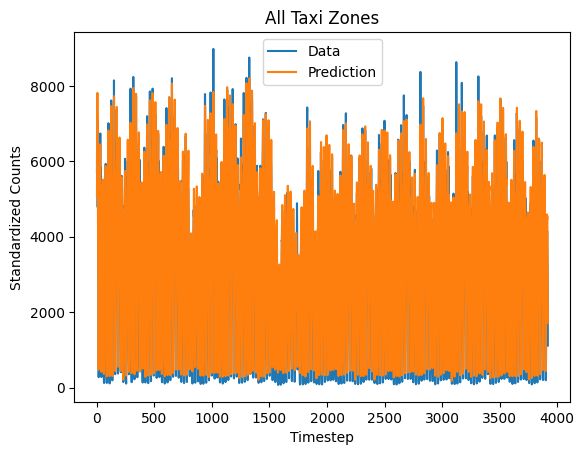

In [210]:
plt.plot(np.sum(y_act_np, axis = 1), label = 'Data')
plt.plot(np.sum(y_pred_np[:,:,0], axis = 1), label = 'Prediction')
plt.title('All Taxi Zones')
plt.xlabel('Timestep')
plt.ylabel('Standardized Counts')
plt.legend()

## Save CSV of Predictions

In [197]:
reverse_mapping = {mapping[i] : i for i in list(mapping.keys())}
np_y_pred = np.array([y_pred[i].detach().numpy() for i in range(len(y_pred))])
np_y_pred = np.squeeze(np_y_pred, -1)

In [198]:
preds_dict = {reverse_mapping[i] : np_y_pred[:,i] for i in range(np_y_pred.shape[-1])}

In [199]:
pdf = pd.DataFrame.from_dict(preds_dict)
pdf.index = pd.date_range(start = pivoted_ts.index[15682],
                          end = pivoted_ts.index[15682] + pd.Timedelta(test_dataset.snapshot_count-1, 'h'), freq = 'h')
pdf

,4,12,13,24,41,42,43,45,48,50,...,237,238,239,243,244,246,249,261,262,263
2023-10-19 14:00:00-04:00,0.949234,5.181470,35.652774,14.636781,11.729183,3.051903,164.109505,6.594369,93.578855,22.040375,...,324.755250,125.788224,192.074060,0.165477,3.517584,84.854225,70.607101,39.549285,85.017207,99.423309
2023-10-19 15:00:00-04:00,2.490709,3.392976,43.960489,17.051152,10.941566,3.371279,186.733196,8.639893,104.239217,25.920901,...,396.040670,146.746181,230.255678,0.256353,2.830049,94.035882,77.212878,39.625900,88.874774,115.490098
2023-10-19 16:00:00-04:00,2.804332,2.498666,40.446787,16.894313,13.247856,4.265672,193.258547,9.996803,107.760961,39.326351,...,445.647178,176.184428,223.549674,0.178250,3.528950,107.999084,102.421153,45.797275,92.875661,133.712097
2023-10-19 17:00:00-04:00,3.795795,1.340218,57.913143,18.587786,16.393357,2.827915,174.597350,8.495391,135.094924,42.741960,...,483.217468,187.239433,270.480229,0.110014,3.222291,146.025558,115.530497,44.183454,104.367955,148.927121
2023-10-19 18:00:00-04:00,3.276913,1.338860,61.841722,20.125801,13.514398,2.602357,177.629415,5.924490,193.703421,47.720328,...,501.508486,182.794473,266.316330,0.097201,2.386470,165.784337,132.094556,50.482344,103.369121,162.410689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-30 18:00:00-04:00,1.424509,1.774698,21.685968,9.962479,10.384193,2.976785,96.486542,8.172156,141.667635,31.193184,...,207.337714,93.614876,140.044988,0.049145,1.613686,111.843675,114.193518,34.649641,43.093753,93.512374
2024-03-30 19:00:00-04:00,2.540555,1.011717,21.394130,7.399998,5.213243,1.904366,62.919970,7.137918,124.298436,17.710441,...,149.323307,59.471438,127.330734,0.162432,1.722969,94.201122,122.417876,24.698229,30.622297,97.797748
2024-03-30 20:00:00-04:00,3.096833,1.395683,13.220200,8.943672,8.305284,2.242073,28.454333,7.736827,129.390195,11.349391,...,120.037549,56.608442,84.355295,0.267952,1.652689,74.525459,126.898369,14.205888,22.027333,78.276099
2024-03-30 21:00:00-04:00,5.524425,0.570605,3.443242,6.456836,4.895709,2.359402,16.997654,3.498164,98.587911,11.582974,...,75.987534,37.056047,51.899268,0.422179,2.277453,60.975480,119.323907,8.279916,15.615457,48.830825


In [200]:
pdf = pdf.unstack(0)
pdf

4    2023-10-19 14:00:00-04:00     0.949234
     2023-10-19 15:00:00-04:00     2.490709
     2023-10-19 16:00:00-04:00     2.804332
     2023-10-19 17:00:00-04:00     3.795795
     2023-10-19 18:00:00-04:00     3.276913
                                    ...    
263  2024-03-30 18:00:00-04:00    93.512374
     2024-03-30 19:00:00-04:00    97.797748
     2024-03-30 20:00:00-04:00    78.276099
     2024-03-30 21:00:00-04:00    48.830825
     2024-03-30 22:00:00-04:00    23.189519
Length: 247023, dtype: float64

In [201]:
pdf = pdf.reset_index()
pdf

,level_0,level_1,0
0,4,2023-10-19 14:00:00-04:00,0.949234
1,4,2023-10-19 15:00:00-04:00,2.490709
2,4,2023-10-19 16:00:00-04:00,2.804332
3,4,2023-10-19 17:00:00-04:00,3.795795
4,4,2023-10-19 18:00:00-04:00,3.276913
...,...,...,...
247018,263,2024-03-30 18:00:00-04:00,93.512374
247019,263,2024-03-30 19:00:00-04:00,97.797748
247020,263,2024-03-30 20:00:00-04:00,78.276099
247021,263,2024-03-30 21:00:00-04:00,48.830825


In [202]:
pdf = pdf.rename(columns = {'level_0' : 'PULocationID', 'level_1' : 'pickup_datetime', 0 : 'counts'})
pdf.set_index('pickup_datetime', inplace=True)
pdf

,PULocationID,counts
pickup_datetime,,
2023-10-19 14:00:00-04:00,4,0.949234
2023-10-19 15:00:00-04:00,4,2.490709
2023-10-19 16:00:00-04:00,4,2.804332
2023-10-19 17:00:00-04:00,4,3.795795
2023-10-19 18:00:00-04:00,4,3.276913
...,...,...
2024-03-30 18:00:00-04:00,263,93.512374
2024-03-30 19:00:00-04:00,263,97.797748
2024-03-30 20:00:00-04:00,263,78.276099


In [203]:
# save predictions as csv
pdf.to_csv('/content/mnt/My Drive/taxi_data/gnn_predictions.csv')

In [204]:
# save model
torch.save(model.state_dict(), '/content/mnt/My Drive/taxi_colab/LSTMGCN_final')